finetune

In [ ]:
!nvidia-smi

Tue Nov  4 14:01:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!unzip mobilevit-1.zip

Archive:  mobilevit-1.zip
   creating: mobilevit-1/
  inflating: mobilevit-1/label_maps.json  
  inflating: mobilevit-1/model.safetensors  
  inflating: mobilevit-1/tasks.json  
  inflating: mobilevit-1/training_args.bin  


In [ ]:
!unzip mobilevit-2.zip

Archive:  mobilevit-2.zip
   creating: mobilevit-2/
  inflating: mobilevit-2/label_maps.json  
  inflating: mobilevit-2/model.safetensors  
  inflating: mobilevit-2/tasks.json  
  inflating: mobilevit-2/training_args.bin  


In [ ]:
!unzip images.zip

Archive:  images.zip
   creating: images/
  inflating: images/team19_139.jpg   
  inflating: images/team19_1759150167457.jpg  
  inflating: images/team19_1759150171670.jpg  
  inflating: images/team19_1759150533744.jpg  
  inflating: images/team19_1759150566575.jpg  
  inflating: images/team19_1759151063226.jpg  
  inflating: images/team19_1759151065948.jpg  
  inflating: images/team19_1759151071735.jpg  
  inflating: images/team19_1759151075529.jpg  
  inflating: images/team19_1759151172870.jpg  
  inflating: images/team19_1759152072987.jpg  
  inflating: images/team19_20191005181729_2.jpg  
  inflating: images/team19_71p++9K+x3L._UF350,350_QL80_.jpg  
  inflating: images/team19_BagBalmMoisturizingSoap_3.9oz_4.jpg  
  inflating: images/team19_BBS_694c45df-7b39-486e-8502-d24f0f0fb456.jpg  
  inflating: images/team19_il_340x270.4258371409_f2hm.jpg  
  inflating: images/team19_il_340x270.6392176763_6uy0.jpg  
  inflating: images/team19_IMG-20250929-WA0021.jpg  
  inflating: images/team19

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import os
import json
import random
from typing import Dict, List, Any

import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset

from datasets import Dataset as HFDataset
import evaluate

from transformers import (
    AutoImageProcessor,
    MobileViTModel,
    Trainer,
    TrainingArguments,
    set_seed,
)

In [ ]:
# -------------------------
# Configuration
# -------------------------
CSV_PATH = "/content/dataset_clean_split.csv"
IMG_ROOT = "/"
OUTPUT_DIR = "/content/mobilevit-multitask-finetuned"
MODEL_NAME = "apple/mobilevit-small"
BATCH_SIZE = 16
NUM_EPOCHS = 10
LR = 2e-5
WEIGHT_DECAY = 1e-4
SEED = 42
MISSING_TOKEN = "N/A"

# specify your chosen attribute tasks explicitly
ATTRIBUTE_TASKS = ["color", "material", "condition", "size", "pattern", "features", "shape", "style"]

In [ ]:
# -------------------------
# Helpers
# -------------------------
def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    set_seed(seed)

def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

In [ ]:
# -------------------------
# Robust CSV Parsing (your functions)
# -------------------------
def parse_attributes(attr_str):
    """Parse 'color:white;material:plastic' → {'color': 'white', 'material': 'plastic'}"""
    if pd.isna(attr_str):
        return {}
    attributes = {}
    try:
        for item in attr_str.split(';'):
            if ':' in item:
                key, value = item.split(':', 1)
                attributes[key.strip()] = value.strip()
    except Exception as e:
        print(f"Error parsing attribute string: {attr_str} | Error: {e}")
    return attributes

def preprocess_dataframe(csv_path, attribute_task_list):
    """Load the single CSV, parse only the specified attributes, and return train/val splits + tasks"""
    print(f"Loading data from {csv_path}...")
    df = pd.read_csv(csv_path)

    print("Parsing 'attributes' column...")
    attr_dicts = df['attributes'].apply(parse_attributes)
    attr_df = pd.DataFrame(attr_dicts.tolist())

    print(f"Filtering for specified attributes: {attribute_task_list}")
    found_attributes = [col for col in attribute_task_list if col in attr_df.columns]
    missing_attributes = [col for col in attribute_task_list if col not in attr_df.columns]

    if missing_attributes:
        print(f"⚠️ Warning: Missing attributes not found in CSV: {missing_attributes}")

    attr_df = attr_df[found_attributes]
    df = pd.concat([df, attr_df], axis=1)
    df[found_attributes] = df[found_attributes].fillna(MISSING_TOKEN)

    task_columns = ["class_label"] + found_attributes

    df_train = df[df["split"].str.lower() == "train"].reset_index(drop=True)
    df_val = df[df["split"].str.lower().isin(["val", "valid", "validation"])].reset_index(drop=True)

    print(f"✅ Created {len(df_train)} training samples and {len(df_val)} validation samples.")
    return df_train, df_val, task_columns

In [ ]:
# -------------------------
# Label mapping
# -------------------------
def make_label_maps(df_trainval: pd.DataFrame, tasks: List[str]) -> Dict[str, Dict[str, Any]]:
    maps = {}
    for t in tasks:
        uniq = sorted(df_trainval[t].fillna(MISSING_TOKEN).astype(str).unique())
        if MISSING_TOKEN not in uniq:
            uniq.append(MISSING_TOKEN)
        label2id = {lbl: i for i, lbl in enumerate(uniq)}
        id2label = {i: lbl for lbl, i in label2id.items()}
        maps[t] = {"label2id": label2id, "id2label": id2label}
    return maps

def apply_label_maps(df: pd.DataFrame, tasks: List[str], label_maps: Dict[str, Dict[str, Any]]) -> pd.DataFrame:
    for t in tasks:
        l2i = label_maps[t]["label2id"]
        df[t] = df[t].fillna(MISSING_TOKEN).astype(str)
        df[f"{t}_id"] = df[t].map(lambda x: l2i.get(x, l2i[MISSING_TOKEN]))
    return df

In [ ]:
# -------------------------
# Dataset
# -------------------------
class MultiTaskImageDataset(Dataset):
    def __init__(self, df, img_root, tasks, processor):
        self.df = df.reset_index(drop=True)
        self.img_root = img_root
        self.tasks = tasks
        self.processor = processor
        self.label_cols = [f"{t}_id" for t in tasks]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["image_path"]
        img_path = os.path.join(self.img_root, path) if self.img_root not in ("", "/") else path
        image = Image.open(img_path).convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze()  # [3, H, W]
        labels = torch.tensor([int(row[col]) for col in self.label_cols], dtype=torch.long)

        return {"pixel_values": pixel_values, "labels": labels}

# -------------------------
# Model
# -------------------------
class MultiTaskMobileViT(nn.Module):
    def __init__(self, model_name: str, num_labels_per_task: List[int], dropout: float = 0.1):
        super().__init__()
        self.backbone = MobileViTModel.from_pretrained(model_name)
        feat_dim = 640
        self.tasks = len(num_labels_per_task)
        self.num_labels_per_task = num_labels_per_task

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(feat_dim, nlab),
            ) for nlab in num_labels_per_task
        ])
        self.criterion = nn.CrossEntropyLoss()
        self.offsets = np.cumsum([0] + num_labels_per_task).tolist()

    def forward(self, pixel_values=None, labels=None, **kwargs):
        outputs = self.backbone(pixel_values=pixel_values)
        features = outputs.pooler_output  # [B, hidden_dim]

        logits_per_task = [head(features) for head in self.heads]
        logits_concat = torch.cat(logits_per_task, dim=-1)

        loss = None
        if labels is not None:
            losses = [self.criterion(logits_per_task[i], labels[:, i]) for i in range(self.tasks)]
            loss = torch.stack(losses).mean()

        return {"loss": loss, "logits": logits_concat}

In [ ]:
# -------------------------
# Collator
# -------------------------
def collate_fn(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch], dim=0)
    labels = torch.stack([b["labels"] for b in batch], dim=0)
    return {"pixel_values": pixel_values, "labels": labels}

In [ ]:
# -------------------------
# Metrics
# -------------------------
def build_compute_metrics(tasks: List[str], num_labels_per_task: List[int]):
    accuracy = evaluate.load("accuracy")
    offsets = np.cumsum([0] + num_labels_per_task).tolist()

    def compute_metrics(eval_pred):
        preds_concat, labels = eval_pred
        per_task_acc = {}
        per_task_scores = []

        for i, task in enumerate(tasks):
            start, end = offsets[i], offsets[i + 1]
            logits_t = preds_concat[:, start:end]
            preds_t = logits_t.argmax(axis=-1)
            acc = accuracy.compute(predictions=preds_t, references=labels[:, i])["accuracy"]
            per_task_acc[task] = acc
            per_task_scores.append(acc)

        avg_acc = float(np.mean(per_task_scores))
        metrics = {f"{t}_accuracy": v for t, v in per_task_acc.items()}
        metrics["average_accuracy"] = avg_acc
        return metrics

    return compute_metrics

In [ ]:
# -------------------------
# Main
# -------------------------
def main():
    ensure_dir(OUTPUT_DIR)
    set_all_seeds(SEED)

    df_train, df_val, tasks = preprocess_dataframe(CSV_PATH, ATTRIBUTE_TASKS)
    df_trainval = pd.concat([df_train, df_val])

    label_maps = make_label_maps(df_trainval, tasks)
    df_train = apply_label_maps(df_train, tasks, label_maps)
    df_val = apply_label_maps(df_val, tasks, label_maps)

    num_labels_per_task = [len(label_maps[t]["label2id"]) for t in tasks]
    print("Label counts per task:", dict(zip(tasks, num_labels_per_task)))

    with open(os.path.join(OUTPUT_DIR, "label_maps.json"), "w") as f:
        json.dump(label_maps, f, indent=2)

    processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

    train_ds = MultiTaskImageDataset(df_train, IMG_ROOT, tasks, processor)
    val_ds = MultiTaskImageDataset(df_val, IMG_ROOT, tasks, processor)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultiTaskMobileViT(MODEL_NAME, num_labels_per_task=num_labels_per_task)
    model.to(device)
    compute_metrics = build_compute_metrics(tasks, num_labels_per_task)

    args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=NUM_EPOCHS,
        learning_rate=LR,
        weight_decay=WEIGHT_DECAY,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="average_accuracy",
        greater_is_better=True,
        remove_unused_columns=False,
        logging_steps=50,
        report_to=["none"],
        fp16=True,  # enables mixed precision for Colab
        seed=SEED,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=None,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    print("\n🚀 Starting training...")
    trainer.train()

    print("\n✅ Validation Results:")
    val_metrics = trainer.evaluate()
    for k, v in val_metrics.items():
        if isinstance(v, (float, int)):
            print(f"{k}: {v:.4f}")

    print("\n💾 Saving final model...")
    trainer.save_model(OUTPUT_DIR)
    with open(os.path.join(OUTPUT_DIR, "tasks.json"), "w") as f:
        json.dump({"tasks": tasks, "num_labels_per_task": num_labels_per_task}, f, indent=2)

    print("\n✅ Done.")

In [ ]:
main()

Loading data from /content/dataset_clean_split.csv...
Parsing 'attributes' column...
Filtering for specified attributes: ['color', 'material', 'condition', 'size', 'pattern', 'features', 'shape', 'style']
✅ Created 9504 training samples and 2376 validation samples.
Label counts per task: {'class_label': 115, 'color': 149, 'material': 36, 'condition': 16, 'size': 6, 'pattern': 6, 'features': 21, 'shape': 33, 'style': 8}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/22.5M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

/tmp/ipython-input-387673670.py:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



🚀 Starting training...


Epoch,Training Loss,Validation Loss,Class Label Accuracy,Color Accuracy,Material Accuracy,Condition Accuracy,Size Accuracy,Pattern Accuracy,Features Accuracy,Shape Accuracy,Style Accuracy,Average Accuracy
1,1.903900,1.764780,0.088805,0.233165,0.400673,0.359428,0.700337,0.954966,0.952862,0.760101,0.949495,0.599981
2,1.534700,1.509207,0.088805,0.220118,0.400673,0.369108,0.700337,0.954966,0.952862,0.760101,0.949495,0.599607
3,1.465600,1.482146,0.088805,0.220118,0.400673,0.385522,0.700337,0.954966,0.952862,0.760101,0.949495,0.601431
4,1.487800,1.470817,0.088805,0.220118,0.400673,0.363215,0.700337,0.954966,0.952862,0.760101,0.949495,0.598952
5,1.476100,1.464987,0.088805,0.220118,0.400673,0.369529,0.700337,0.954966,0.952862,0.760101,0.949495,0.599654
6,1.490300,1.460531,0.088805,0.220118,0.400673,0.452020,0.700337,0.954966,0.952862,0.760101,0.949495,0.608820
7,1.457800,1.456376,0.088805,0.220118,0.400673,0.454966,0.700337,0.954966,0.952862,0.760101,0.949495,0.609147
8,1.473400,1.450503,0.088805,0.221380,0.400673,0.459175,0.700337,0.954966,0.952862,0.760101,0.949495,0.609755
9,1.459300,1.446520,0.088805,0.223064,0.400673,0.462963,0.700337,0.954966,0.952862,0.760101,0.949495,0.610363
10,1.420100,1.446319,0.088805,0.226010,0.400673,0.463384,0.700337,0.954966,0.952862,0.760101,0.949495,0.610737



✅ Validation Results:


eval_loss: 1.4463
eval_class_label_accuracy: 0.0888
eval_color_accuracy: 0.2260
eval_material_accuracy: 0.4007
eval_condition_accuracy: 0.4634
eval_size_accuracy: 0.7003
eval_pattern_accuracy: 0.9550
eval_features_accuracy: 0.9529
eval_shape_accuracy: 0.7601
eval_style_accuracy: 0.9495
eval_average_accuracy: 0.6107
eval_runtime: 11.5639
eval_samples_per_second: 205.4670
eval_steps_per_second: 12.8850
epoch: 10.0000

💾 Saving final model...

✅ Done.


In [ ]:
!zip -r mobilevit_small_2.zip /content/mobilevit-multitask-finetuned

  adding: content/mobilevit-multitask-finetuned/ (stored 0%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-1782/ (stored 0%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-1782/optimizer.pt (deflated 9%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-1782/trainer_state.json (deflated 78%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-1782/scaler.pt (deflated 64%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-1782/scheduler.pt (deflated 61%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-1782/model.safetensors (deflated 7%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-1782/rng_state.pth (deflated 26%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-1782/training_args.bin (deflated 53%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-2970/ (stored 0%)
  adding: content/mobilevit-multitask-finetuned/checkpoint-2970/optimizer.pt (deflated 9%)
  adding: content/mobilevit-multitask-

inference 1

In [ ]:
# =========================
# Multi-task MobileViT — Single Random Image Inference (GPU)
# =========================

import os, json, random, torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from transformers import AutoImageProcessor, MobileViTModel
import torch.nn as nn

# ----- CONFIG -----
MODEL_DIR  = "/content/mobilevit-multitask-finetuned"
CHECKPOINT = "/content/mobilevit-multitask-finetuned/model.safetensors"
BASE_MODEL = "apple/mobilevit-small"
IMAGE_DIR  = "/content/images"   # folder containing your test images
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {DEVICE}")

# ----- Define model wrapper -----
class MultiTaskMobileViT(nn.Module):
    def __init__(self, model_name: str, num_labels_per_task: list, dropout: float = 0.1):
        super().__init__()
        self.backbone = MobileViTModel.from_pretrained(model_name)
        feat_dim = 640
        self.tasks = len(num_labels_per_task)
        self.num_labels_per_task = num_labels_per_task
        self.heads = nn.ModuleList([
            nn.Sequential(nn.Dropout(dropout), nn.Linear(feat_dim, nlab))
            for nlab in num_labels_per_task
        ])
        self.offsets = np.cumsum([0] + num_labels_per_task).tolist()

    def forward(self, pixel_values):
        outputs = self.backbone(pixel_values=pixel_values)
        feats = outputs.pooler_output
        logits_per_task = [head(feats) for head in self.heads]
        logits_concat = torch.cat(logits_per_task, dim=-1)
        return {"logits": logits_concat}

# ----- Load model + label maps -----
def load_model(model_dir, checkpoint_path, base_model, device):
    with open(os.path.join(model_dir, "tasks.json"), "r") as f:
        task_info = json.load(f)
    tasks = task_info["tasks"]
    num_labels_per_task = task_info["num_labels_per_task"]

    with open(os.path.join(model_dir, "label_maps.json"), "r") as f:
        label_maps = json.load(f)
    id2label = {t: {int(k): v for k, v in maps["id2label"].items()} for t, maps in label_maps.items()}

    print(f"🔹 Loading weights from: {checkpoint_path}")
    weights = load_file(checkpoint_path)

    model = MultiTaskMobileViT(base_model, num_labels_per_task)
    model.load_state_dict(weights, strict=True)
    model.to(device).eval()

    processor = AutoImageProcessor.from_pretrained(base_model)
    offsets = np.cumsum([0] + num_labels_per_task).tolist()
    return model, processor, tasks, id2label, offsets

# ----- Prediction -----
@torch.no_grad()
def predict_single(model, processor, tasks, id2label, offsets, image, device):
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.autocast(device_type="cuda", enabled=(device.type == "cuda")):
        logits = model(pixel_values=inputs["pixel_values"])["logits"]

    preds = {}
    for t_idx, task in enumerate(tasks):
        s, e = offsets[t_idx], offsets[t_idx + 1]
        pred_id = int(logits[0, s:e].argmax(-1).item())
        preds[task] = id2label[task].get(pred_id, f"ID_{pred_id}")
    return preds

# ----- Visualize -----
def visualize(image, preds):
    plt.imshow(image)
    plt.axis("off")
    title = f"{preds['class_label']}\n" + ", ".join(
        [f"{k}: {v}" for k, v in preds.items() if k != "class_label"][:4]
    )
    plt.title(title, fontsize=10)
    plt.show()

# ----- Main -----
def main():
    model, processor, tasks, id2label, offsets = load_model(MODEL_DIR, CHECKPOINT, BASE_MODEL, DEVICE)

    # Randomly select one image from your test folder
    all_images = [os.path.join(IMAGE_DIR, f)
                  for f in os.listdir(IMAGE_DIR)
                  if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    if not all_images:
        raise ValueError(f"No images found in {IMAGE_DIR}")
    image_path = random.choice(all_images)
    print(f"\n🎯 Selected image: {os.path.basename(image_path)}")

    # Load and predict
    image = Image.open(image_path).convert("RGB")
    preds = predict_single(model, processor, tasks, id2label, offsets, image, DEVICE)

    # Show results
    print("\n=== Prediction for this image ===")
    print(f"Class: {preds['class_label']}")
    for t, v in preds.items():
        if t != "class_label":
            print(f"  {t}: {v}")

    visualize(image, preds)

🔥 Using device: cuda


🔹 Loading weights from: /content/mobilevit-multitask-finetuned/model.safetensors

🎯 Selected image: Team12_Sports_Wickets_009.jpg

=== Prediction for this image ===
Class: pen
  color: white
  material: plastic
  condition: unknown
  size: unknown
  pattern: unknown
  features: unknown
  shape: unknown
  style: unknown


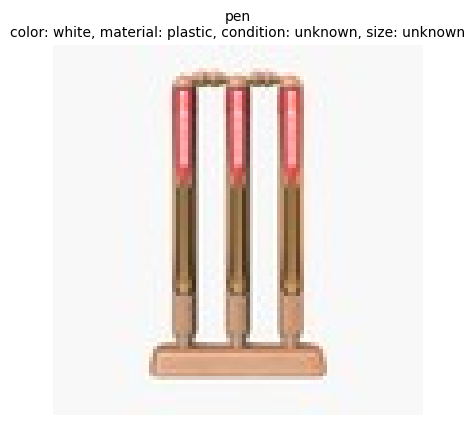

In [ ]:
main()

retrieval system - search index based

In [ ]:
# =====================================
# 🔍 MobileViT Retrieval System (search-index based)
# =====================================

import os, json, torch, pandas as pd, numpy as np
from PIL import Image
from tqdm.auto import tqdm
from safetensors.torch import load_file
from transformers import AutoImageProcessor, MobileViTModel
import torch.nn as nn
import spacy
import matplotlib.pyplot as plt
import random

# ----- CONFIG -----
MODEL_DIR = "/content/mobilevit-multitask-finetuned"
CHECKPOINT = "/content/mobilevit-multitask-finetuned/model.safetensors"
CSV_PATH = "/content/dataset_clean_split.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Using device: {DEVICE}")

# ----- LOAD LABEL MAPS -----
with open(os.path.join(MODEL_DIR, "label_maps.json"), "r") as f:
    label_maps = json.load(f)
id_to_label = {t: {int(k): v for k, v in maps["id2label"].items()} for t, maps in label_maps.items()}
label_to_id = {t: {v: int(k) for k, v in maps["id2label"].items()} for t, maps in label_maps.items()}

with open(os.path.join(MODEL_DIR, "tasks.json"), "r") as f:
    task_info = json.load(f)
tasks = task_info["tasks"]
num_labels_per_task = task_info["num_labels_per_task"]

# ----- DEFINE MODEL -----
class MultiTaskMobileViT(nn.Module):
    def __init__(self, model_name, num_labels_per_task, dropout=0.1):
        super().__init__()
        self.backbone = MobileViTModel.from_pretrained(model_name)
        feat_dim = 640
        self.heads = nn.ModuleList([
            nn.Sequential(nn.Dropout(dropout), nn.Linear(feat_dim, nlab))
            for nlab in num_labels_per_task
        ])
        self.offsets = np.cumsum([0] + num_labels_per_task).tolist()
        self.tasks = tasks

    def forward(self, pixel_values):
        feats = self.backbone(pixel_values=pixel_values).pooler_output
        logits_per_task = [head(feats) for head in self.heads]
        return {"logits": logits_per_task}

# ----- LOAD MODEL WEIGHTS -----
model = MultiTaskMobileViT("apple/mobilevit-small", num_labels_per_task)
state_dict = load_file(CHECKPOINT)
model.load_state_dict(state_dict, strict=True)
model.to(DEVICE).eval()
print("✅ MobileViT fine-tuned model loaded.")

# ----- LOAD PROCESSOR -----
processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

# ----- LOAD DATA -----
df = pd.read_csv(CSV_PATH)
df = df[df['split'].isin(['train', 'val', 'test'])]  # keep all
print(f"📁 Loaded {len(df)} images for indexing.")

# ----- BUILD SEARCH INDEX -----
search_index = []
all_tags = set()

with torch.no_grad():
    for i in tqdm(range(len(df)), desc="Building index"):
        row = df.iloc[i]
        image_path = row["image_path"]
        if not os.path.exists(image_path):
            continue
        image = Image.open(image_path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(DEVICE)
        outputs = model(**inputs)["logits"]

        image_tags = []
        for t_idx, task in enumerate(tasks):
            logits = outputs[t_idx].squeeze()
            pred_idx = torch.argmax(logits).item()
            pred_label = id_to_label[task].get(pred_idx, "N/A")
            if pred_label != "N/A":
                if task == "class_label":
                    image_tags.extend(pred_label.split('_'))
                else:
                    image_tags.append(pred_label)
                all_tags.add(pred_label)

        search_index.append({"image_path": image_path, "tags": image_tags})

print(f"🔍 Search index built for {len(search_index)} images.")
print(f"Unique tags found: {len(all_tags)}")

# ----- NLP for query parsing -----
try:
    nlp = spacy.load("en_core_web_sm")
except Exception as e:
    print("Downloading spaCy model...")
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

def extract_keywords(text):
    doc = nlp(text.lower())
    keywords = set(token.lemma_ for token in doc if token.pos_ in ("NOUN", "ADJ", "PROPN"))
    if not keywords and text:
        keywords = set(text.lower().split())
    return keywords

def retrieve_images(query, index, top_k=5):
    query_keywords = extract_keywords(query)
    print(f"Searching for: {query_keywords}")
    results = []
    for item in index:
        score = len(query_keywords.intersection(set(item["tags"])))
        if score > 0:
            results.append({**item, "score": score})
    results.sort(key=lambda x: x["score"], reverse=True)
    return results[:top_k]


🔥 Using device: cuda
✅ MobileViT fine-tuned model loaded.
📁 Loaded 11880 images for indexing.


Building index:   0%|          | 0/11880 [00:00<?, ?it/s]

🔍 Search index built for 11880 images.
Unique tags found: 9


In [ ]:
from collections import Counter

# 1️⃣ Flatten all tags
all_tags_flat = [tag for img in search_index for tag in img["tags"]]
tag_counts = Counter(all_tags_flat)

print(f"\nTotal tags predicted: {len(all_tags_flat)}")
print(f"Unique tags predicted: {len(tag_counts)}\n")

print("Top 30 predicted tags:")
for tag, count in tag_counts.most_common(30):
    print(f"{tag:20s}  {count}")


Total tags predicted: 107014
Unique tags predicted: 10

Top 30 predicted tags:
unknown               63873
plastic               11880
pen                   11785
black                 11519
used                  7407
white                 342
water                 94
bottle                94
blue                  19
notebook              1


In [ ]:
import json, os
maps_path = "/content/mobilevit-multitask-finetuned/label_maps.json"
with open(maps_path) as f:
    maps = json.load(f)
for t, v in maps.items():
    print(f"{t:12s} → {len(v['id2label'])} labels")

class_label  → 115 labels
color        → 149 labels
material     → 36 labels
condition    → 16 labels
size         → 6 labels
pattern      → 6 labels
features     → 21 labels
shape        → 33 labels
style        → 8 labels


In [ ]:
import random

for _ in range(10):
    sample = random.choice(search_index)
    print(os.path.basename(sample["image_path"]), "→", sample["tags"])

team10_stationery_pen_039.jpg → ['pen', 'black', 'plastic', 'used', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
team24_mug_025.jpg → ['pen', 'black', 'plastic', 'used', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
team23_wallet_059.jpg → ['pen', 'black', 'plastic', 'used', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
team14_soap_bar (12).jpg → ['pen', 'black', 'plastic', 'used', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
team13_tableware_water_bottle_041.jpg → ['pen', 'black', 'plastic', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
team5_backpack_21.jpg → ['pen', 'black', 'plastic', 'used', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
team25_mouse_32.jpg → ['pen', 'black', 'plastic', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
team11_pencil_058.jpg → ['pen', 'black', 'plastic', 'used', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']
team25_calculator_31.jpg → ['pen', 'black', 'plastic

Searching for: {'mug', 'blue'}

Top results for: 'a blue mug'
Score: 1 | Tags: ['pen', 'blue', 'plastic', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown'] | images/team14_pen (51).jpg
Score: 1 | Tags: ['pen', 'blue', 'plastic', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown'] | images/team14_pen (55).jpg
Score: 1 | Tags: ['pen', 'blue', 'plastic', 'used', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown'] | images/team14_pen (69).jpg
Score: 1 | Tags: ['pen', 'blue', 'plastic', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown'] | images/Team1_pen_B_3_248.jpg
Score: 1 | Tags: ['pen', 'blue', 'plastic', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown'] | images/Team1_pen_B_4_249.jpg


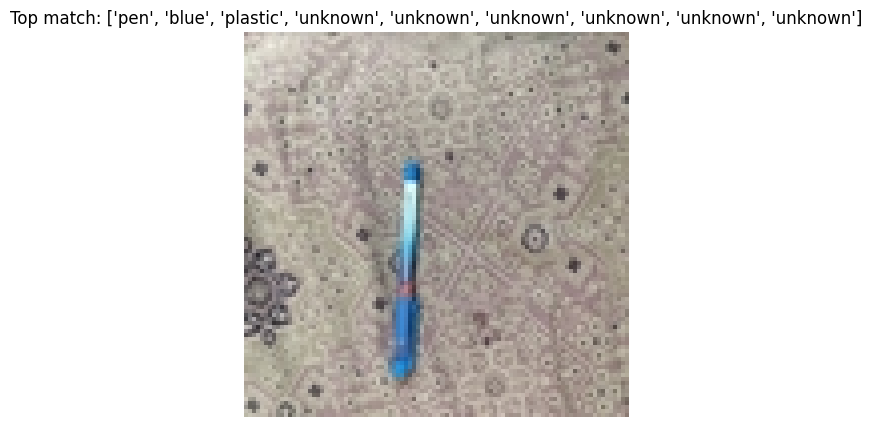

In [ ]:
# ----- DEMO -----
query = "a blue mug"
results = retrieve_images(query, search_index, top_k=5)

if results:
    print(f"\nTop results for: '{query}'")
    for r in results:
        print(f"Score: {r['score']} | Tags: {r['tags']} | {r['image_path']}")
    # visualize top hit
    img = Image.open(results[0]["image_path"])
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(f"Top match: {results[0]['tags']}")
    plt.axis("off")
    plt.show()
else:
    print("No matches found.")

top k

In [ ]:
# ----- DEMO -----
query = "a blue mug"
top_k = 5
results = retrieve_images(query, search_index, top_k=top_k)

if results:
    print(f"\nTop {top_k} results for: '{query}'\n")
    for i, r in enumerate(results, 1):
        print(f"{i}. Score: {r['score']} | Tags: {r['tags']} | {r['image_path']}")

    # ----- Visualization -----
    plt.figure(figsize=(4 * top_k, 5))
    for i, r in enumerate(results[:top_k]):
        try:
            img = Image.open(r["image_path"]).convert("RGB")
            plt.subplot(1, top_k, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{i+1}: {', '.join(r['tags'][:3])}", fontsize=9)
        except Exception as e:
            print(f"⚠️ Could not open {r['image_path']}: {e}")
    plt.tight_layout()
    plt.show()

else:
    print(f"No matches found for '{query}'.")

evals

dataset 1 vs dataset 2

In [ ]:
import pandas as pd
import os

# --- Configuration ---
YOUR_DATA_CSV = '/content/newlabels.csv'
POOLED_DATA_CSV = '/content/dataset_clean_split.csv'

NEW_YOUR_DATA_CSV = '/content/newlabels_fixed.csv'
NEW_POOLED_DATA_CSV = '/content/dataset_clean_split_fixed.csv'

# --- Process 'Your Data' (newlabels.csv) ---
try:
    df_your = pd.read_csv(YOUR_DATA_CSV)
    # Replace 'images/' with 'images1/' at the start of the string
    df_your['image_path'] = df_your['image_path'].str.replace(r'^images/', 'images1/', n=1, regex=True)
    df_your.to_csv(NEW_YOUR_DATA_CSV, index=False)
    print(f"✅ Successfully created: {NEW_YOUR_DATA_CSV}")
    print("New 'Your Data' paths look like this:")
    print(df_your['image_path'].head(2))

except Exception as e:
    print(f"❌ Error processing {YOUR_DATA_CSV}: {e}")

print("\n" + "="*30 + "\n")

# --- Process 'Pooled Data' (dataset_clean_split.csv) ---
try:
    df_pooled = pd.read_csv(POOLED_DATA_CSV)
    # Replace 'images/' with 'images2/' at the start of the string
    df_pooled['image_path'] = df_pooled['image_path'].str.replace(r'^images/', 'images2/', n=1, regex=True)
    df_pooled.to_csv(NEW_POOLED_DATA_CSV, index=False)
    print(f"✅ Successfully created: {NEW_POOLED_DATA_CSV}")
    print("New 'Pooled Data' paths look like this:")
    print(df_pooled['image_path'].head(2))

except Exception as e:
    print(f"❌ Error processing {POOLED_DATA_CSV}: {e}")

✅ Successfully created: /content/newlabels_fixed.csv
New 'Your Data' paths look like this:
0    images1/team19_IMG_20250929_160719.jpg
1    images1/team19_IMG_20250929_160745.jpg
Name: image_path, dtype: object


✅ Successfully created: /content/dataset_clean_split_fixed.csv
New 'Pooled Data' paths look like this:
0    images2/team14_wrist_watch (1).jpg
1    images2/team14_wrist_watch (2).jpg
Name: image_path, dtype: object


✅ Model and Dataset classes defined.
✅ Evaluation functions defined.

🚀 Analyzing: MobileViT / Your Data
Loaded tasks: ['class_label', 'color', 'material', 'condition', 'size']
✅ Model weights loaded.
Parsing 'attributes' column for val set...
✅ Loaded 149 validation samples.
✅ Generated predictions for 149 samples.

------------------------------
  Task: class_label
------------------------------
Accuracy: 0.3087
F1 (Weighted): 0.2784
F1 (Macro): 0.2514

Classification Report:
                                  precision    recall  f1-score   support

electronics_accessories_keyboard       0.21      0.60      0.31        15
   electronics_accessories_mouse       0.12      0.07      0.09        15
               footwear_sneakers       0.86      0.40      0.55        15
           personal_care_shampoo       0.00      0.00      0.00        14
              personal_care_soap       0.25      0.20      0.22        15
        personal_care_toothbrush       0.38      0.20      0.26        1

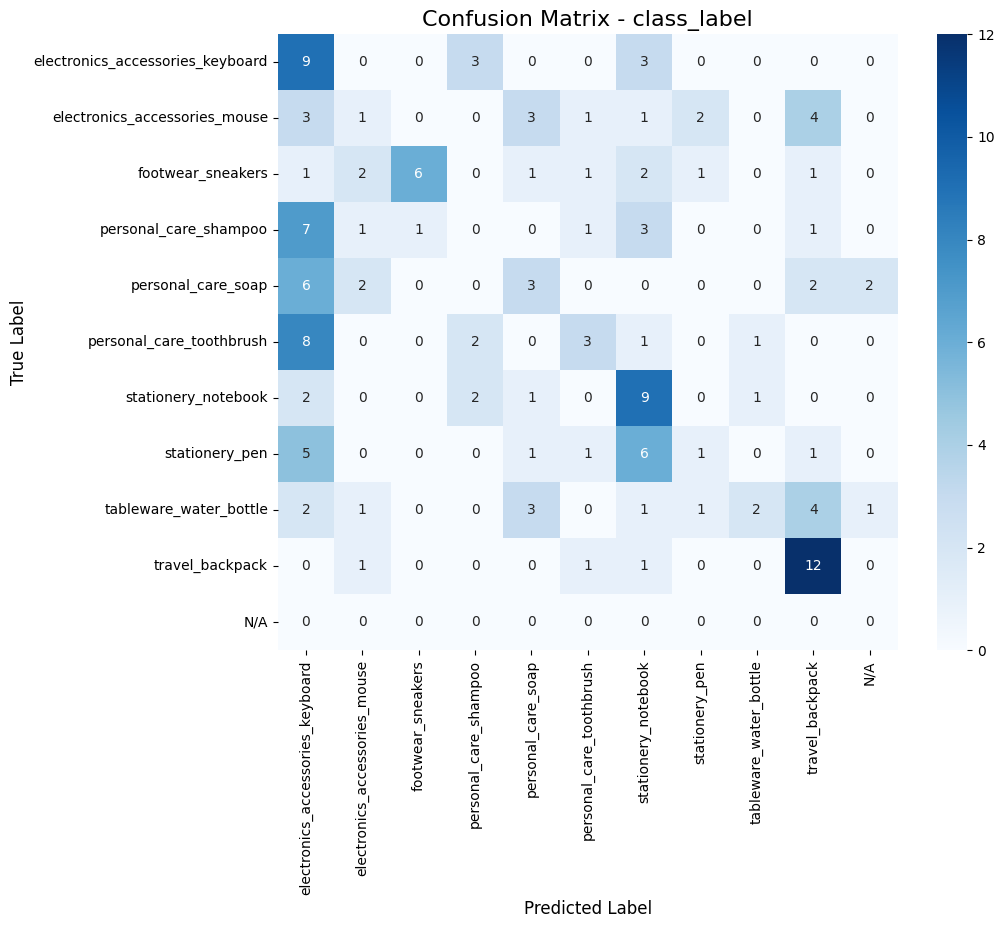


------------------------------
  Task: color
------------------------------
Accuracy: 0.1141
F1 (Weighted): 0.1310
F1 (Macro): 0.0228

Classification Report:
                 precision    recall  f1-score   support

            N/A       0.00      0.00      0.00         1
          black       0.42      0.43      0.43        30
 black and blue       0.00      0.00      0.00         0
           blue       0.43      0.09      0.14        35
 blue and white       0.00      0.00      0.00         0
blue and yellow       0.00      0.00      0.00         0
          brown       0.00      0.00      0.00         0
          cream       0.00      0.00      0.00         0
    crimson red       0.00      0.00      0.00         0
     dark green       0.00      0.00      0.00         5
      dark grey       0.00      0.00      0.00         0
      deep blue       0.00      0.00      0.00         0
           gold       0.00      0.00      0.00         0
          green       0.00      0.00      

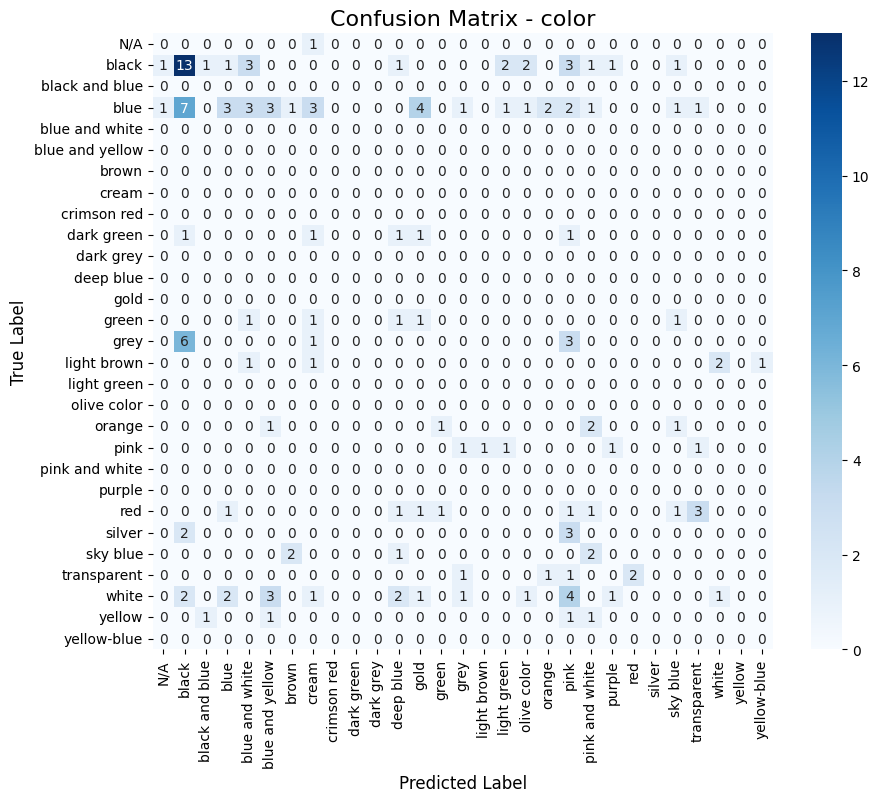


------------------------------
  Task: material
------------------------------
Accuracy: 0.4362
F1 (Weighted): 0.4273
F1 (Macro): 0.2058

Classification Report:
              precision    recall  f1-score   support

         N/A       0.00      0.00      0.00         1
      fabric       0.71      0.33      0.45        30
       metal       0.00      0.00      0.00         5
       paper       0.20      0.07      0.10        15
     plastic       0.56      0.70      0.62        73
        soap       0.08      0.13      0.10        15
       steel       0.50      0.10      0.17        10

    accuracy                           0.44       149
   macro avg       0.29      0.19      0.21       149
weighted avg       0.48      0.44      0.43       149



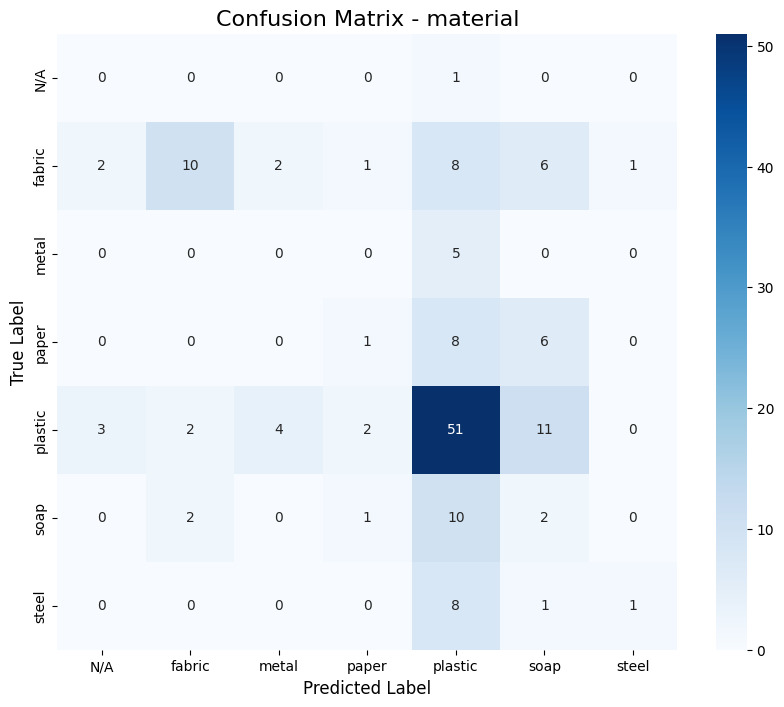


------------------------------
  Task: condition
------------------------------
Accuracy: 0.6174
F1 (Weighted): 0.6323
F1 (Macro): 0.3033

Classification Report:
              precision    recall  f1-score   support

         N/A       0.00      0.00      0.00         1
      broken       0.00      0.00      0.00         0
         new       0.56      0.44      0.49        55
        used       0.72      0.73      0.72        93

    accuracy                           0.62       149
   macro avg       0.32      0.29      0.30       149
weighted avg       0.65      0.62      0.63       149



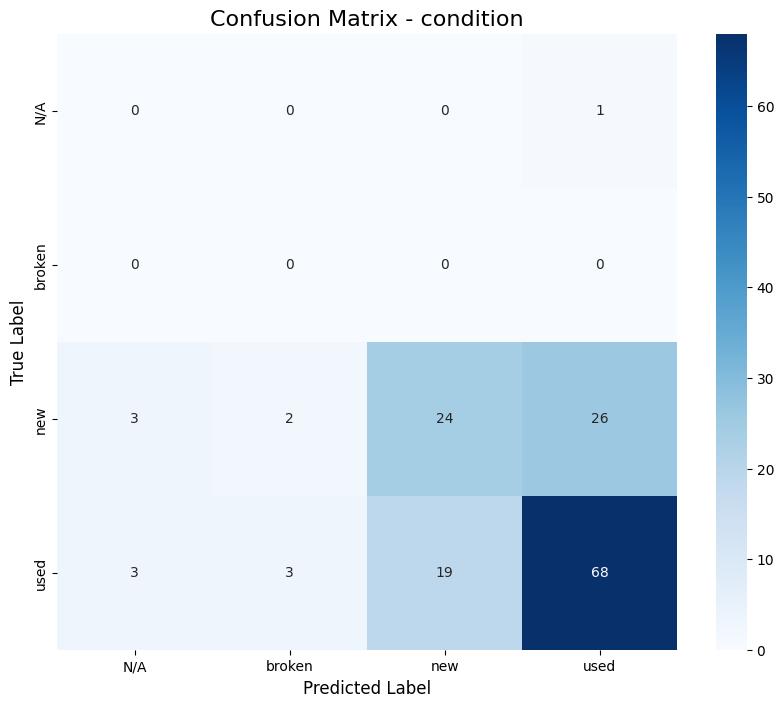


------------------------------
  Task: size
------------------------------
Accuracy: 0.7248
F1 (Weighted): 0.7557
F1 (Macro): 0.2690

Classification Report:
              precision    recall  f1-score   support

         N/A       0.00      0.00      0.00         1
       large       0.00      0.00      0.00         5
      medium       0.89      0.82      0.85       128
       small       0.25      0.20      0.22        15

    accuracy                           0.72       149
   macro avg       0.28      0.26      0.27       149
weighted avg       0.79      0.72      0.76       149



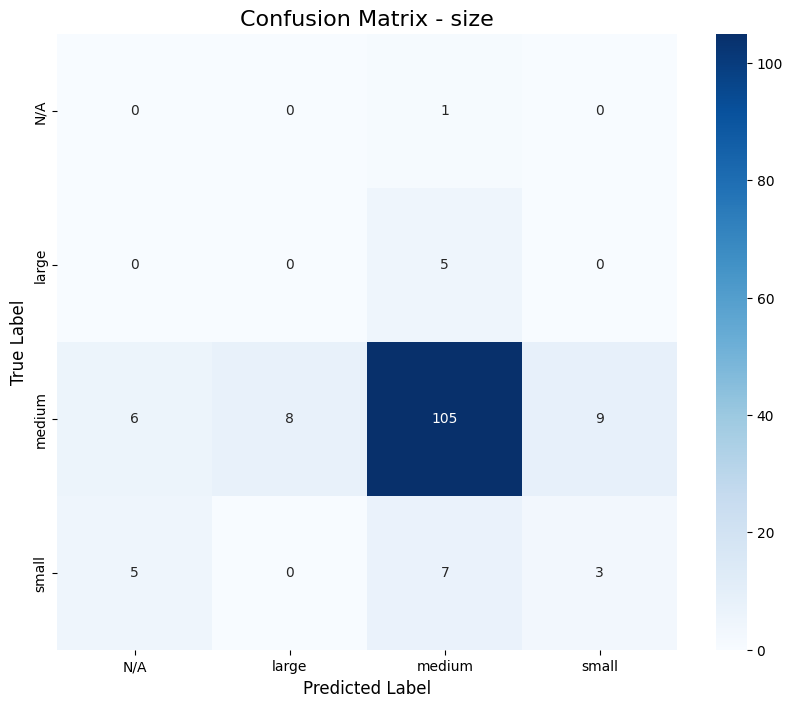


🚀 Analyzing: MobileViT / Pooled Data
Loaded tasks: ['class_label', 'color', 'material', 'condition', 'size', 'pattern', 'features', 'shape', 'style']
✅ Model weights loaded.
Parsing 'attributes' column for val set...
✅ Loaded 2376 validation samples.
✅ Generated predictions for 2376 samples.

------------------------------
  Task: class_label
------------------------------
Accuracy: 0.0888
F1 (Weighted): 0.0146
F1 (Macro): 0.0014

Classification Report:
                   precision    recall  f1-score   support

               ac       0.00      0.00      0.00         2
        ambulance       0.00      0.00      0.00         3
         backpack       0.00      0.00      0.00       122
 badminton_racket       0.00      0.00      0.00         5
         band_aid       0.00      0.00      0.00         2
     bandage_roll       0.00      0.00      0.00         4
     baseball_bat       0.00      0.00      0.00         2
       basketball       0.00      0.00      0.00        10
         

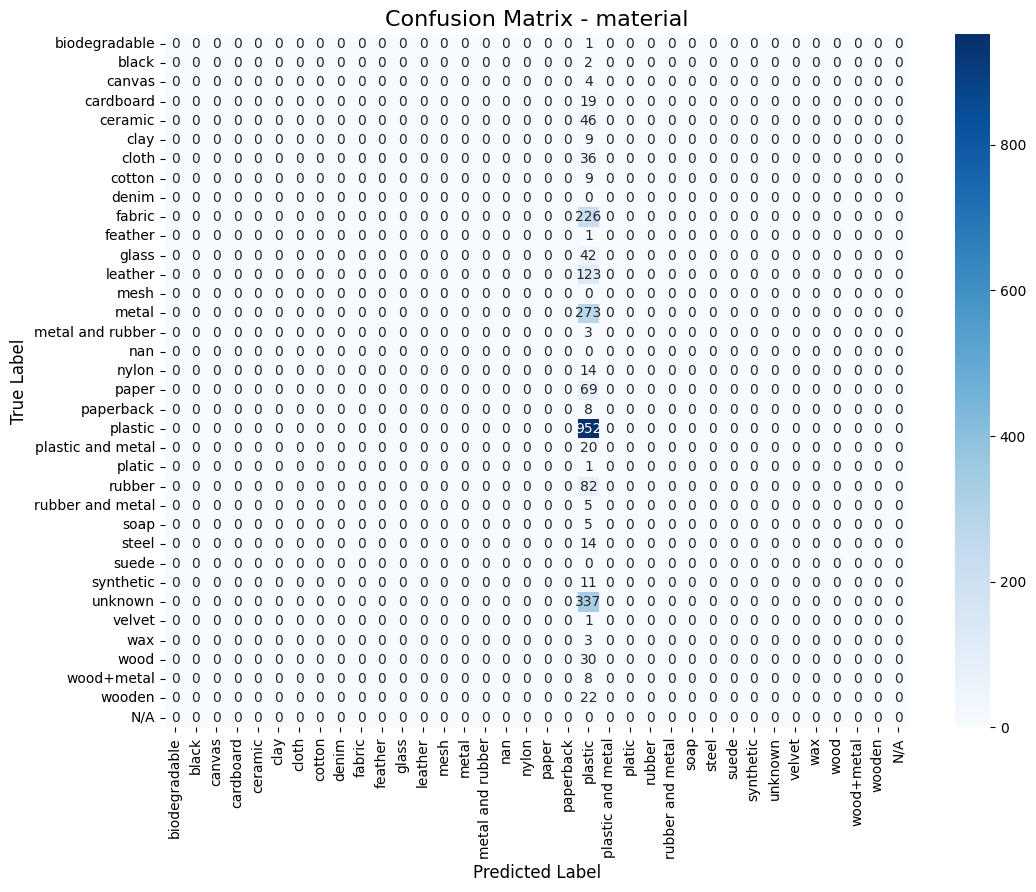


------------------------------
  Task: condition
------------------------------
Accuracy: 0.4630
F1 (Weighted): 0.3761
F1 (Macro): 0.0684

Classification Report:
                  precision    recall  f1-score   support

          broken       0.00      0.00      0.00         1
        deformed       0.00      0.00      0.00         1
            mint       0.00      0.00      0.00        17
             nan       0.00      0.00      0.00         0
             new       0.00      0.00      0.00       544
            new"       0.00      0.00      0.00        33
 new,size:medium       0.00      0.00      0.00        20
  new,size:small       0.00      0.00      0.00        10
             old       0.00      0.00      0.00        15
            old"       0.00      0.00      0.00        85
         unknown       0.53      0.54      0.54       850
            used       0.42      0.81      0.56       785
used,size:medium       0.00      0.00      0.00         1
 used,size:small       0

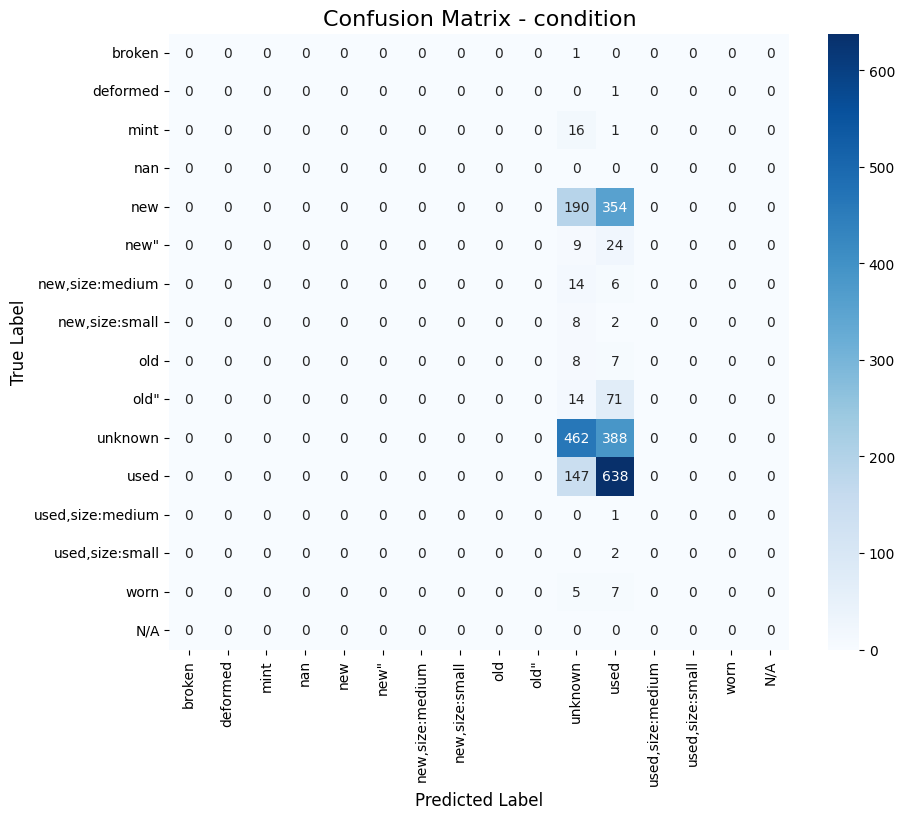


------------------------------
  Task: size
------------------------------
Accuracy: 0.7003
F1 (Weighted): 0.5769
F1 (Macro): 0.1373

Classification Report:
              precision    recall  f1-score   support

 extra small       0.00      0.00      0.00         0
       large       0.00      0.00      0.00       157
      medium       0.00      0.00      0.00       345
       small       0.00      0.00      0.00       210
     unknown       0.70      1.00      0.82      1664
         N/A       0.00      0.00      0.00         0

    accuracy                           0.70      2376
   macro avg       0.12      0.17      0.14      2376
weighted avg       0.49      0.70      0.58      2376



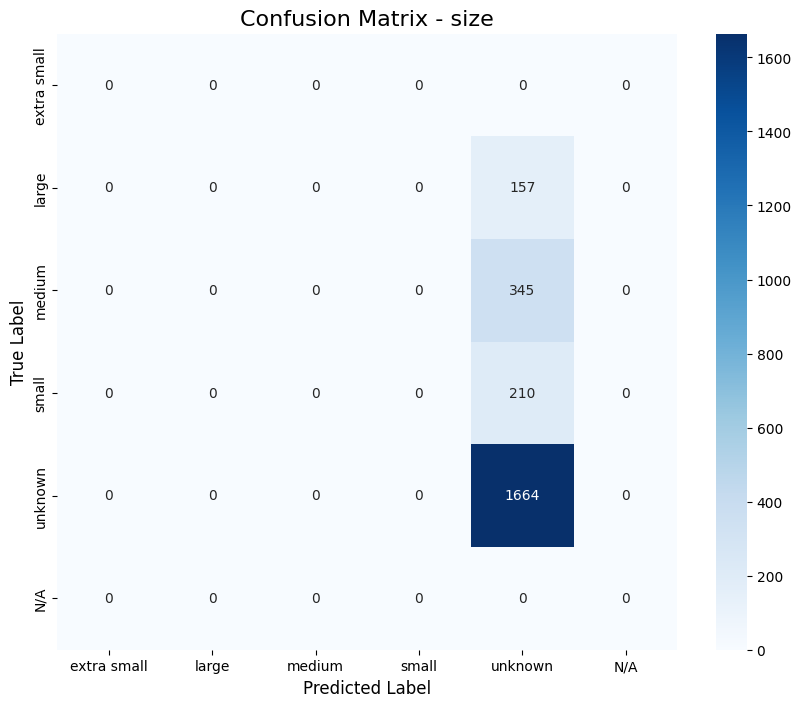


------------------------------
  Task: pattern
------------------------------
Accuracy: 0.9550
F1 (Weighted): 0.9330
F1 (Macro): 0.1628

Classification Report:
              precision    recall  f1-score   support

   patterned       0.00      0.00      0.00         9
       plain       0.00      0.00      0.00        79
     striped       0.00      0.00      0.00         5
    textured       0.00      0.00      0.00        14
     unknown       0.95      1.00      0.98      2269
         N/A       0.00      0.00      0.00         0

    accuracy                           0.95      2376
   macro avg       0.16      0.17      0.16      2376
weighted avg       0.91      0.95      0.93      2376



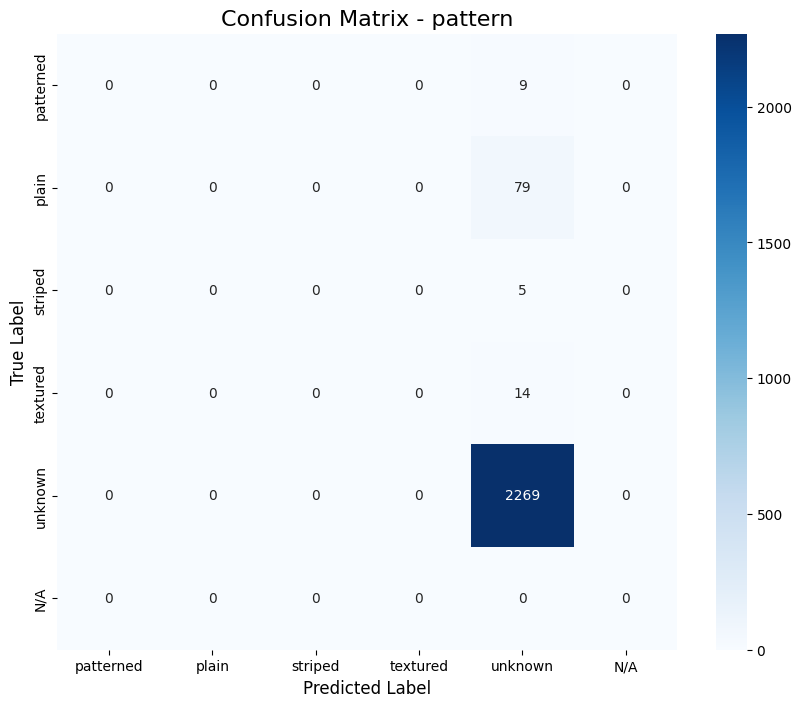


------------------------------
  Task: features
------------------------------
Accuracy: 0.9529
F1 (Weighted): 0.9299
F1 (Macro): 0.0465

Classification Report:
                 precision    recall  f1-score   support

         analog       0.00      0.00      0.00         8
        digital       0.00      0.00      0.00         3
        general       0.00      0.00      0.00         4
      hairbrush       0.00      0.00      0.00         7
          round       0.00      0.00      0.00         5
          smart       0.00      0.00      0.00         2
        unknown       0.95      1.00      0.98      2264
          wired       0.00      0.00      0.00         3
       wireless       0.00      0.00      0.00         6
       with_cap       0.00      0.00      0.00        14
     with_chain       0.00      0.00      0.00         0
    with_handle       0.00      0.00      0.00        17
     with_laces       0.00      0.00      0.00        12
   with_pockets       0.00      0.00   

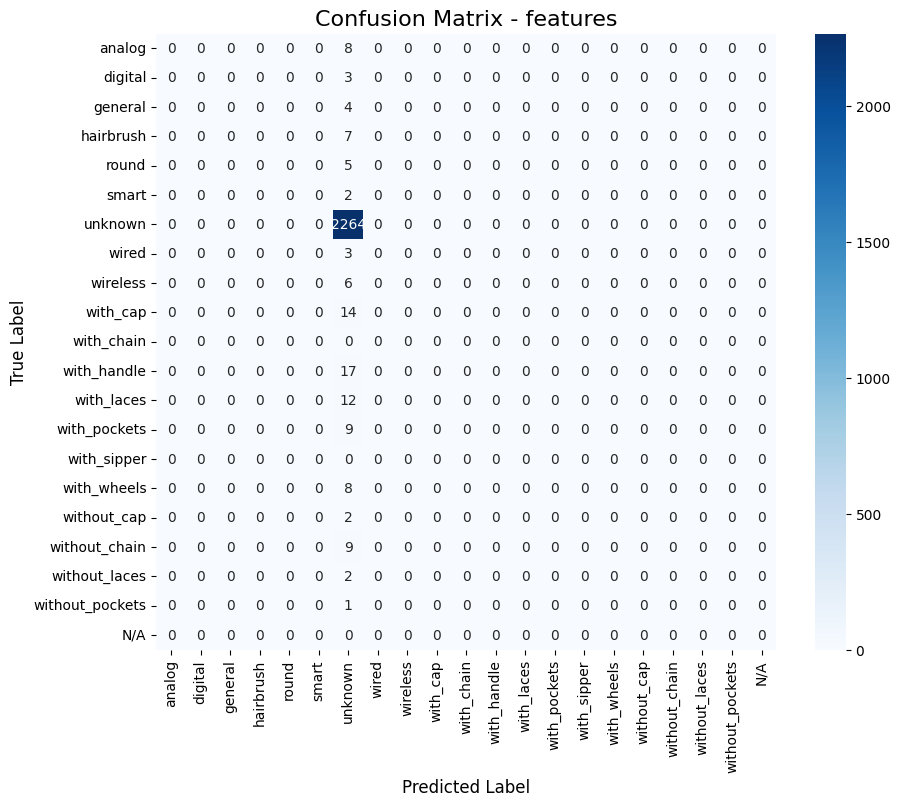


------------------------------
  Task: shape
------------------------------
Accuracy: 0.7601
F1 (Weighted): 0.6565
F1 (Macro): 0.0262

Classification Report:
                          precision    recall  f1-score   support

               A-shape "       0.00      0.00      0.00        13
                circular       0.00      0.00      0.00         7
          circular, band       0.00      0.00      0.00         4
          circular, flat       0.00      0.00      0.00         2
                 conical       0.00      0.00      0.00        15
                  cuboid       0.00      0.00      0.00         1
         cuboid, vehicle       0.00      0.00      0.00         3
             cylindrical       0.00      0.00      0.00        93
            cylindrical"       0.00      0.00      0.00        28
cylindrical, symmetrical       0.00      0.00      0.00         5
                 ellipse       0.00      0.00      0.00         0
          elongated_oval       0.00      0.00   

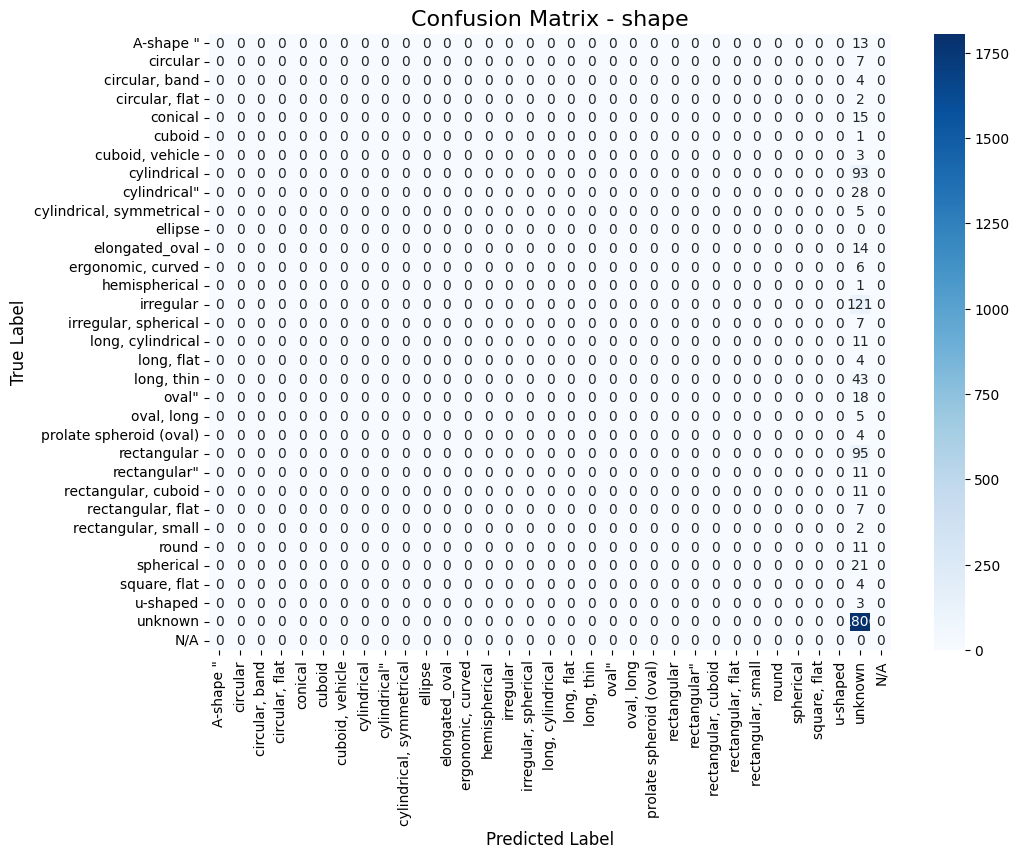


------------------------------
  Task: style
------------------------------
Accuracy: 0.9495
F1 (Weighted): 0.9249
F1 (Macro): 0.1218

Classification Report:
              precision    recall  f1-score   support

      casual       0.00      0.00      0.00        21
      formal       0.00      0.00      0.00         2
  minimalist       0.00      0.00      0.00        22
      modern       0.00      0.00      0.00        39
      sports       0.00      0.00      0.00        17
     unknown       0.95      1.00      0.97      2256
     vintage       0.00      0.00      0.00        19
         N/A       0.00      0.00      0.00         0

    accuracy                           0.95      2376
   macro avg       0.12      0.12      0.12      2376
weighted avg       0.90      0.95      0.92      2376



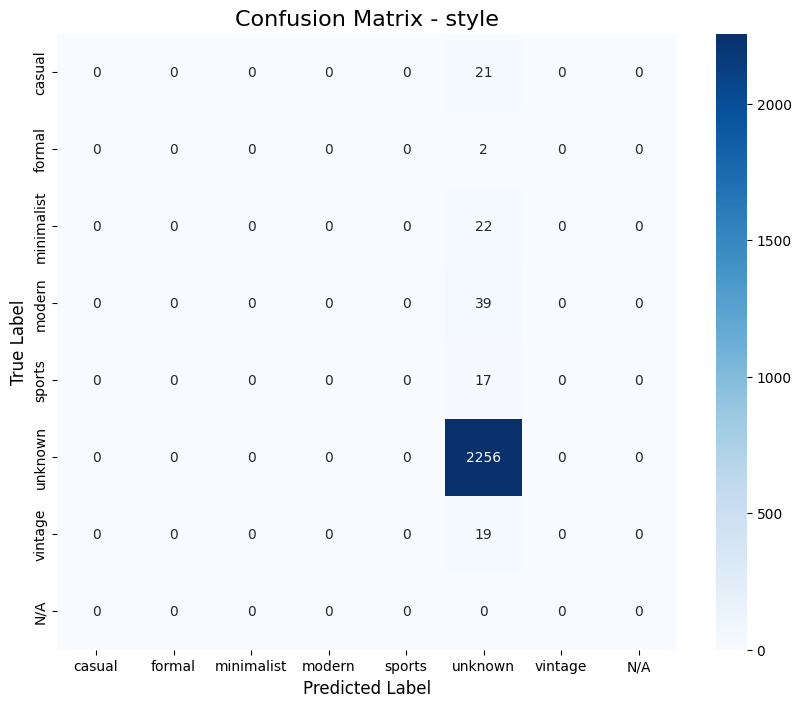



          📊 FINAL METRICS SUMMARY (on Validation Set)
| Model     | Dataset     |   Avg. Accuracy |   Avg. F1 (Weighted) |   Avg. F1 (Macro) |   Class Label F1 (W) |
|:----------|:------------|----------------:|---------------------:|------------------:|---------------------:|
| MobileViT | Your Data   |          0.4403 |               0.4449 |            0.2104 |               0.2784 |
| MobileViT | Pooled Data |          0.6107 |               0.5258 |            0.0648 |               0.0146 |


In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from typing import Dict, List, Any

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, MobileViTModel
from safetensors.torch import load_file # <--- ADDED THIS IMPORT

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- 1. Re-use Your Dataset Class ---
# (Copied directly from your training script)
class MultiTaskImageDataset(Dataset):
    def __init__(self, df, img_root, tasks, processor):
        self.df = df.reset_index(drop=True)
        self.img_root = img_root
        self.tasks = tasks
        self.processor = processor
        self.label_cols = [f"{t}_id" for t in tasks]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["image_path"]

        # --- THIS IS THE CHANGE ---
        # No more 'if/else'. We ALWAYS join the root with the path.
        img_path = os.path.join(self.img_root, path)

        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Warning: Could not find image {img_path}. Returning a dummy tensor.")
            image = Image.new('RGB', (224, 224), color='black') # Dummy image

        inputs = self.processor(images=image, return_tensors="pt")
        pixel_values = inputs["pixel_values"].squeeze()  # [3, H, W]
        labels = torch.tensor([int(row[col]) for col in self.label_cols], dtype=torch.long)

        return {"pixel_values": pixel_values, "labels": labels}

# --- 2. Re-use Your Model Class ---
# (Copied directly from your training script)
class MultiTaskMobileViT(nn.Module):
    def __init__(self, model_name: str, num_labels_per_task: List[int], dropout: float = 0.1):
        super().__init__()
        self.backbone = MobileViTModel.from_pretrained(model_name)
        feat_dim = 640  # MobileViT-Small's pooler output dim
        self.tasks = len(num_labels_per_task)
        self.num_labels_per_task = num_labels_per_task

        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Dropout(dropout),
                nn.Linear(feat_dim, nlab),
            ) for nlab in num_labels_per_task
        ])
        self.offsets = np.cumsum([0] + num_labels_per_task).tolist()

    def forward(self, pixel_values=None, **kwargs):
        outputs = self.backbone(pixel_values=pixel_values)
        features = outputs.pooler_output  # [B, hidden_dim]

        logits_per_task = [head(features) for head in self.heads]
        logits_concat = torch.cat(logits_per_task, dim=-1)

        # Return dict matching Trainer's expectation (loss isn't needed for eval)
        return {"logits": logits_concat}

print("✅ Model and Dataset classes defined.")

# --- 3. Define Evaluation Helper Functions ---

@torch.no_grad()
def get_all_predictions(model, dataloader, device):
    """Run inference and return all concatenated logits and labels."""
    model.to(device)
    model.eval()

    all_logits = []
    all_labels = []

    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"] # Keep labels on CPU

        outputs = model(pixel_values=pixel_values)
        logits_concat = outputs['logits']

        all_logits.append(logits_concat.cpu())
        all_labels.append(labels)

    all_logits_cat = torch.cat(all_logits, dim=0)
    all_labels_cat = torch.cat(all_labels, dim=0)

    return all_logits_cat, all_labels_cat

def plot_task_confusion_matrix(labels, preds, class_names, all_label_ids, title): # <--- ADDED all_label_ids
    """Plots a confusion matrix for a single task."""

    # --- THIS IS THE FIX ---
    # Force the matrix to be the full size, even with missing labels
    cm = confusion_matrix(labels, preds, labels=all_label_ids)
    # ---

    # Don't plot if too large (e.g., > 50 classes)
    if len(class_names) > 50:
        print(f"Skipping confusion matrix for '{title}' (too many classes: {len(class_names)})")
        return

    plt.figure(figsize=(max(10, len(class_names)//3), max(8, len(class_names)//4)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

def run_analysis(all_logits, all_labels, tasks, offsets, label_maps):
    """Calculates metrics and plots for all tasks."""

    all_task_metrics = {}

    for i, task_name in enumerate(tasks):
        print("\n" + "-"*30)
        print(f"  Task: {task_name}")
        print( "-"*30)

        # 1. Get preds/labels for this task
        start, end = offsets[i], offsets[i + 1]
        task_logits = all_logits[:, start:end]
        task_preds = torch.argmax(task_logits, dim=1).numpy()
        task_labels = all_labels[:, i].numpy()

        # 2. Get class names for this task
        id2label = label_maps[task_name]['id2label']
        # Ensure class names are in the correct order (0, 1, 2...)
        task_class_names = [id2label[str(j)] for j in range(len(id2label))]

        # --- THIS IS THE FIX (Part 1) ---
        # Create a list of all possible integer IDs, e.g., [0, 1, ..., 28]
        all_label_ids = list(range(len(task_class_names)))
        # ---

        # 3. Calculate Metrics
        acc = accuracy_score(task_labels, task_preds)
        f1_w = f1_score(task_labels, task_preds, average='weighted', labels=all_label_ids, zero_division=0)
        f1_micro = f1_score(task_labels, task_preds, average='micro', labels=all_label_ids, zero_division=0)
        f1_macro = f1_score(task_labels, task_preds, average='macro', labels=all_label_ids, zero_division=0)

        print(f"Accuracy: {acc:.4f}")
        print(f"F1 (Weighted): {f1_w:.4f}")
        print(f"F1 (Macro): {f1_macro:.4f}")

        all_task_metrics[task_name] = {'accuracy': acc, 'f1_weighted': f1_w, 'f1_macro': f1_macro}

        # 4. Print Classification Report (for per-class scores)
        print("\nClassification Report:")

        # --- THIS IS THE FIX (Part 2) ---
        # Add the 'labels' parameter
        print(classification_report(task_labels, task_preds, target_names=task_class_names, labels=all_label_ids, zero_division=0))
        # ---

        # 5. Plot Confusion Matrix (for misclassifications)

        # --- THIS IS THE FIX (Part 3) ---
        # Pass all_label_ids to the plotting function
        plot_task_confusion_matrix(task_labels, task_preds, task_class_names, all_label_ids, f"Confusion Matrix - {task_name}")
        # ---

    return all_task_metrics

print("✅ Evaluation functions defined.")

# --- 4. Main Orchestration ---

# (Re-using helper functions from your script)
def parse_attributes(attr_str):
    if pd.isna(attr_str): return {}
    attributes = {}
    try:
        for item in attr_str.split(';'):
            if ':' in item:
                key, value = item.split(':', 1)
                attributes[key.strip()] = value.strip()
    except Exception: pass
    return attributes

def apply_label_maps(df: pd.DataFrame, tasks: List[str], label_maps: Dict[str, Dict[str, Any]], missing_token="N/A") -> pd.DataFrame:
    for t in tasks:
        l2i = label_maps[t]["label2id"]
        df[t] = df[t].fillna(missing_token).astype(str)
        df[f"{t}_id"] = df[t].map(lambda x: l2i.get(x, l2i[missing_token]))
    return df

# ---
# !! TODO: Make sure these paths are correct !!
# ---
CONFIGS = {
    'MobileViT / Your Data': {
        'model_dir': '/content/mobilevit-1', # <--- !! UPDATE THIS !!
        'model_class': MultiTaskMobileViT,
        'model_name_hf': 'apple/mobilevit-small',
        'csv_path': '/content/newlabels_fixed.csv',       # <--- Using your fixed CSV
        'img_root': '/content/'
    },
    'MobileViT / Pooled Data': {
        'model_dir': '/content/mobilevit-2', # <--- From your training script
        'model_class': MultiTaskMobileViT,
        'model_name_hf': 'apple/mobilevit-small',
        'csv_path': '/content/dataset_clean_split_fixed.csv', # <--- Using your fixed CSV
        'img_root': '/content/'
    }
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_summary = []

for config_name, config in CONFIGS.items():
    print("\n" + "="*70)
    print(f"🚀 Analyzing: {config_name}")
    print("="*70)

    try:
        # 1. Load Tasks and Label Maps (saved by your trainer)
        with open(os.path.join(config['model_dir'], "tasks.json")) as f:
            task_info = json.load(f)
            tasks = task_info['tasks']
            num_labels_per_task = task_info['num_labels_per_task']
            offsets = np.cumsum([0] + num_labels_per_task).tolist()

        with open(os.path.join(config['model_dir'], "label_maps.json")) as f:
            label_maps = json.load(f)

        print(f"Loaded tasks: {tasks}")

        # 2. Load Model
        model = config['model_class'](
            model_name=config['model_name_hf'],
            num_labels_per_task=num_labels_per_task
        )

        # Load weights from .safetensors
        weights_path = os.path.join(config['model_dir'], 'model.safetensors')
        state_dict = load_file(weights_path)
        model.load_state_dict(state_dict)

        print("✅ Model weights loaded.")

        # 3. Load 'val' data  <--- !! THIS SECTION IS UPDATED !! ---
        processor = AutoImageProcessor.from_pretrained(config['model_name_hf'])

        df_full = pd.read_csv(config['csv_path'])

        # --- Handle Attributes ---
        print("Parsing 'attributes' column for val set...")
        attr_dicts = df_full['attributes'].apply(parse_attributes)
        attr_df = pd.DataFrame(attr_dicts.tolist())
        found_attributes = [col for col in tasks if col in attr_df.columns]
        attr_df = attr_df[found_attributes]
        df_full = pd.concat([df_full, attr_df], axis=1)
        df_full[found_attributes] = df_full[found_attributes].fillna("N/A")

        # --- Get 'val' split and apply maps ---
        df_val = df_full[df_full["split"].str.lower() == "val"].reset_index(drop=True) # <-- CHANGED
        df_val = apply_label_maps(df_val, tasks, label_maps)

        val_ds = MultiTaskImageDataset(df_val, config['img_root'], tasks, processor) # <-- CHANGED
        val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2) # <-- CHANGED

        print(f"✅ Loaded {len(val_ds)} validation samples.") # <-- CHANGED

        if len(val_ds) == 0:
            print("⚠️ Error: No 'val' samples found. Check your CSV 'split' column.")
            continue

        # 4. Run Evaluation
        all_logits, all_labels = get_all_predictions(model, val_loader, device) # <-- CHANGED
        print(f"✅ Generated predictions for {len(all_labels)} samples.")

        # 5. Get Metrics and Plots
        all_task_metrics = run_analysis(all_logits, all_labels, tasks, offsets, label_maps)

        # 6. Store Summary
        avg_f1_weighted = np.mean([m['f1_weighted'] for m in all_task_metrics.values()])
        avg_f1_macro = np.mean([m['f1_macro'] for m in all_task_metrics.values()])
        avg_accuracy = np.mean([m['accuracy'] for m in all_task_metrics.values()])

        model_name_short, dataset_name = config_name.split(' / ')
        final_summary.append({
            'Model': model_name_short,
            'Dataset': dataset_name,
            'Avg. Accuracy': avg_accuracy,
            'Avg. F1 (Weighted)': avg_f1_weighted,
            'Avg. F1 (Macro)': avg_f1_macro,
            'Class Label F1 (W)': all_task_metrics['class_label']['f1_weighted']
        })

    except Exception as e:
        print(f"❌ FAILED to process {config_name}. Error: {e}")
        import traceback
        traceback.print_exc()

# --- 5. Print Final Summary Table ---
print("\n\n" + "="*70)
print("          📊 FINAL METRICS SUMMARY (on Validation Set)") # <-- CHANGED
print("="*70)

if final_summary:
    summary_df = pd.DataFrame(final_summary)
    print(summary_df.to_markdown(index=False, floatfmt=".4f"))
else:
    print("No results to summarize.")

In [ ]:
# --- 5. Print and Save Final Summary Table ---
print("\n\n" + "="*70)
print("          📊 FINAL METRICS SUMMARY (on Validation Set)")
print("="*70)

if final_summary:
    summary_df = pd.DataFrame(final_summary)

    # --- 1. Print to console ---
    markdown_table = summary_df.to_markdown(index=False, floatfmt=".4f")
    print(markdown_table)

    # --- 2. Save to files ---
    try:
        # Define file paths (they will save in your main /content/ directory)
        csv_path = "/content/mobilevit_summary_results.csv"
        md_path = "/content/mobilevit_summary_results.md"

        # Save as CSV
        summary_df.to_csv(csv_path, index=False)
        print(f"\n✅ Successfully saved CSV summary to: {csv_path}")

        # Save as Markdown file (for easy copy-paste to your report)
        with open(md_path, 'w') as f:
            f.write("MobileViT Metrics Summary (on Validation Set)\n")
            f.write("="*40 + "\n")
            f.write(markdown_table)
        print(f"✅ Successfully saved Markdown summary to: {md_path}")

    except Exception as e:
        print(f"\n❌ Error saving summary files: {e}")

else:
    print("No results to summarize.")



          📊 FINAL METRICS SUMMARY (on Validation Set)
| Model     | Dataset     |   Avg. Accuracy |   Avg. F1 (Weighted) |   Avg. F1 (Macro) |   Class Label F1 (W) |
|:----------|:------------|----------------:|---------------------:|------------------:|---------------------:|
| MobileViT | Your Data   |          0.4403 |               0.4449 |            0.2104 |               0.2784 |
| MobileViT | Pooled Data |          0.6107 |               0.5258 |            0.0648 |               0.0146 |

✅ Successfully saved CSV summary to: /content/mobilevit_summary_results.csv
✅ Successfully saved Markdown summary to: /content/mobilevit_summary_results.md
